## 中风预测
### 第11组

## I. 介绍
NHANES 数据集包含大量特征，包括人口统计、病史、体检结果到饮食和生活方式等问卷调查。已知导致中风的因素，例如血压、血清胆固醇水平、饮酒量、体重等，将选择其他特征进行相关性评估和机器学习模型开发。
本篇主要包括数据清洗、不平衡数据集处理、从 1000 多个维度中选择特征以及模型训练。

In [2]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## II. 数据预处理
### Datasets

In [3]:
# datasets path and df names
path = [
    'dataset\\demographic.csv',
    'dataset\\examination.csv',
    'dataset\\questionnaire.csv',
    'dataset\\labs.csv',
    'dataset\\diet.csv'
]

dfname = [
    'dm',
    'exam',
    'qs',
    'lab',
    'diet'
]

In [4]:
# 读入数据

df = {}
dfn = dict(zip(dfname, path))

df = {key: pd.read_csv(value) for key, value in dfn.items()}

In [5]:
from functools import partial, reduce
Xs = {key: value for key, value in df.items() if key in ['dm', 'exam', 'lab']}
dfs = Xs.values()


# 创建一个偏函数，将默认参数包装一个可调用对象，返回结果也是可调用对象。偏函数可以固定住原函数的部分参数，从而在调用时更简单。
# 设定 SEQN（即人物序号）为拼接的主键，拼接的时候按照这个键左右拼接
inner_merge = partial(pd.merge, how='inner', on='SEQN')
# 将一个序列归纳为一个输出
c = reduce(inner_merge, dfs)
print(f'数据集的大小为 {c.shape}')

# 查找是否有重复的SEQN，并确认有多少行
print(c.SEQN.duplicated().value_counts())
c.to_csv('training_data.csv', index=None)

数据集的大小为 (9813, 693)
False    9813
Name: SEQN, dtype: int64


In [6]:
# show combined df
qs = df['qs'][['SEQN', 'MCQ160F']]
print('中风数据为')
qs

中风数据为


,SEQN,MCQ160F
0,73557,1.0
1,73558,2.0
2,73559,2.0
3,73560,NaN
4,73561,2.0
...,...,...
10170,83727,2.0
10171,83728,NaN
10172,83729,2.0
10173,83730,NaN


In [7]:
# 制作数据集，将c和qs两个数据集按照SEQN为主键合并，并以左表为标志
c = pd.merge(c, qs, how='left', on='SEQN')
c

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,URDUTLLC,URXUTU,URDUTULC,URXUUR,URDUURLC,URXPREG,URXUAS,LBDB12,LBDB12SI,MCQ160F
0,73557,8,2,1,69,NaN,4,4,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,524.0,386.7,1.0
1,73558,8,2,1,54,NaN,3,3,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,507.0,374.2,2.0
2,73559,8,2,1,72,NaN,3,3,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,732.0,540.2,2.0
3,73560,8,2,1,9,NaN,3,3,1.0,119.0,...,0.0,0.238,0.0,0.0071,0.0,NaN,3.83,NaN,NaN,NaN
4,73561,8,2,2,73,NaN,3,3,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,225.0,166.1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9808,83727,8,2,1,26,NaN,2,2,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,720.0,531.4,2.0
9809,83728,8,2,2,2,24.0,1,1,2.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9810,83729,8,2,2,42,NaN,4,4,2.0,NaN,...,0.0,0.132,0.0,0.0081,0.0,2.0,9.75,388.0,286.3,2.0
9811,83730,8,2,1,7,NaN,2,2,1.0,84.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
c.MCQ160F.value_counts()

2.0    5389
1.0     194
9.0       5
Name: MCQ160F, dtype: int64

### 删除MCQ160F列数据为null或者NA的行
我们预测的标签是MCQ160F列，其含义为“是否有医生告诉过你你中风了”

In [9]:
c.MCQ160F.notnull()

0        True
1        True
2        True
3       False
4        True
        ...  
9808     True
9809    False
9810     True
9811    False
9812    False
Name: MCQ160F, Length: 9813, dtype: bool

In [10]:
# 删除MCQ160F列值为NULL或者9的行
c = c[(c.MCQ160F.notnull()) & (c.MCQ160F != 9)]

# 确认数据
c.MCQ160F.describe()

count    5583.000000
mean        1.965252
std         0.183158
min         1.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: MCQ160F, dtype: float64

In [11]:
# 确认标签的值
c.MCQ160F.value_counts()

2.0    5389
1.0     194
Name: MCQ160F, dtype: int64

### 解释文本
- 通过Beauti Soup分析出来的SAS标签解释文档
https://www.kaggle.com/lcchennn/nhanes-2013-2014-codebook-with-sas-label

In [12]:
cbook = pd.read_csv('dataset\\nhanes_2013_2014_codebook.csv')

cbook

,variable,label
0,SEQN,Respondent sequence number
1,SDDSRVYR,Data release cycle
2,RIDSTATR,Interview/Examination status
3,RIAGENDR,Gender
4,RIDAGEYR,Age in years at screening
...,...,...
3901,WHD140,Self-reported greatest weight (pounds)
3902,WHQ150,Age when heaviest weight
3903,WHQ030M,How do you consider your weight
3904,WHQ500,Trying to do about weight


### Data Cleaning

In [24]:
d.dropna(thresh=0.5*len(d), axis=1)

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,RIDEXMON,DMQMILIZ,DMDBORN4,...,LBXTC,LBDTCSI,LBXTTG,WTSH2YR.y,URXUTRI,URXVOL1,URDFLOW1,LBDB12,LBDB12SI,MCQ160F
0,73557,8,2,1,69,4,4,1.0,1.0,1,...,167.0,4.32,2.0,NaN,NaN,87.0,0.821,524.0,386.7,1.0
1,73558,8,2,1,54,3,3,1.0,2.0,1,...,170.0,4.40,2.0,49123.400015,2.0,90.0,1.636,507.0,374.2,2.0
2,73559,8,2,1,72,3,3,2.0,1.0,1,...,126.0,3.26,2.0,115794.742161,NaN,66.0,NaN,732.0,540.2,2.0
4,73561,8,2,2,73,3,3,1.0,2.0,1,...,201.0,5.20,2.0,NaN,NaN,5.0,0.109,225.0,166.1,2.0
5,73562,8,2,1,56,1,1,1.0,1.0,1,...,226.0,5.84,2.0,47860.935312,2.0,197.0,1.187,750.0,553.5,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9804,83723,8,2,1,61,1,1,2.0,2.0,1,...,186.0,4.81,2.0,NaN,NaN,42.0,0.119,621.0,458.3,2.0
9805,83724,8,2,1,80,3,3,1.0,2.0,1,...,157.0,4.06,2.0,59490.431883,NaN,72.0,0.706,837.0,617.7,2.0
9807,83726,8,2,1,40,1,1,1.0,2.0,2,...,NaN,NaN,NaN,NaN,2.0,38.0,1.056,NaN,NaN,2.0
9808,83727,8,2,1,26,2,2,2.0,2.0,1,...,190.0,4.91,2.0,NaN,2.0,48.0,0.462,720.0,531.4,2.0


In [26]:
# 排除没有数字类型的列
d = c.select_dtypes(['number'])

# 排除超过50%的数据都为NAN的列
d = d.dropna(thresh=0.5*len(d), axis=1)

print(len(d.columns), 'columns left')

284 columns left


In [27]:
# 把标签数据从1，2改成0（没中风），1（中风）
d['MCQ160F'] = d.apply(lambda x: 1 if x.MCQ160F == 1 else 0, axis='columns')
d.MCQ160F.value_counts()

0    5389
1     194
Name: MCQ160F, dtype: int64

## III. 特征选择
参考资料：使用机器学习预测糖尿病和心血管疾病的数据驱动方法<br><br>
https://pubmed.ncbi.nlm.nih.gov/31694707/

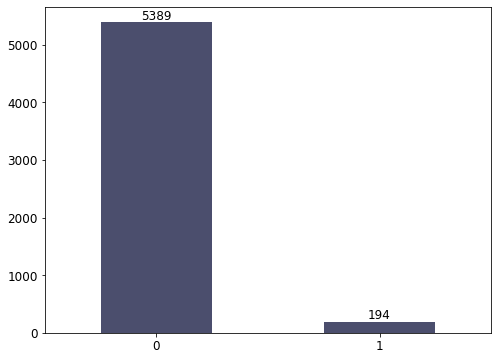

In [14]:
vals = d.MCQ160F.value_counts()

plt.figure(figsize=(8, 6))
plt.rc('font', size=12)

ax = vals.plot.bar(rot=0, color='#4B4E6D')

for i in range(len(vals)):
    ax.annotate(vals[i], xy=[vals.index[i], vals[i]], ha='center', va='bottom')

In [15]:
from sklearn.impute import SimpleImputer
imp_mode = SimpleImputer(strategy='most_frequent')

d = pd.DataFrame(imp_mode.fit_transform(d), columns=d.columns)

### Train/Test Split

In [16]:
X = d.loc[:, d.columns != 'MCQ160F']
y = d.MCQ160F

In [17]:
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (5583, 152)
y shape: (5583,)


In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=12)

### XGBClassifier for feature selection
From the classificaiton result, the accuracy is pretty decent. However once look into the confusion matrix we can see there is only 1 correct prediction for class 1 (recall for class 1 is bad). This is commonly seen for imbalanced dataset, which the classes in the dataset have highly uneven sample sizes. Imbalanced problems is often seen in healthcare  datasets.

In [19]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


def confusion(y_test, y_pred):
    conf = pd.DataFrame(confusion_matrix(y_test, y_pred), index=[
                        'True[0]', 'True[1]'], columns=['Predict[0]', 'Predict[1]'])
    print('Confusion Matrix:')
    print(conf)
    return conf


confusion(y_test, y_pred)

D:\anaconda\envs\ReconNet\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:12:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 96.33%
Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        1075           1
True[1]          40           1


,Predict[0],Predict[1]
True[0],1075,1
True[1],40,1


### Upsampling minority class
In the following cells the minority class is upsampled with SMOTE (Synthetic Minority Oversampling Technique).

In [20]:
y_test.value_counts()

0.0    1076
1.0      41
Name: MCQ160F, dtype: int64

#### Oversampling with SMOTE

In [21]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
X_test_sm, y_test_sm = smote.fit_resample(X_test, y_test)

X_train_sm = pd.DataFrame(X_train_sm, columns=X.columns)
X_test_sm = pd.DataFrame(X_test_sm, columns=X.columns)

In [22]:
import imblearn
print(imblearn.__version__)

0.7.0


In [23]:
print(y_train_sm.value_counts())
print(y_test_sm.value_counts())

0.0    4313
1.0    4313
Name: MCQ160F, dtype: int64
0.0    1076
1.0    1076
Name: MCQ160F, dtype: int64


#### Check the Classification Result Again
After oversampling, the classification result is more reasonable.

In [24]:
model = XGBClassifier()
model.fit(X_train_sm, y_train_sm)
y_pred_sm = model.predict(X_test_sm)

accuracy = accuracy_score(y_test_sm, y_pred_sm)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
conf = pd.DataFrame(confusion_matrix(y_test_sm, y_pred_sm), index=[
                    'True[0]', 'True[1]'], columns=['Predict[0]', 'Predict[1]'])
conf

[20:12:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda\envs\ReconNet\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 96.70%


,Predict[0],Predict[1]
True[0],1073,3
True[1],68,1008


### Feature Selection with XGBoost

[20:12:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda\envs\ReconNet\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


<AxesSubplot:>

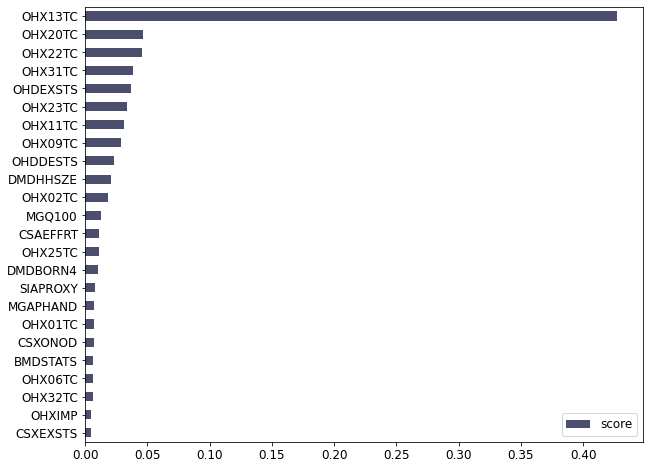

In [25]:
from xgboost import XGBClassifier
from matplotlib import pyplot

# fit model no training data
model = XGBClassifier()
model.fit(X_train_sm, y_train_sm)

# Features selected by XGBoost
keys = list(model.get_booster().feature_names)
values = list(model.feature_importances_)

data = pd.DataFrame(data=values, index=keys, columns=[
                    "score"]).sort_values(by="score", ascending=False)

# Top 24 features
xgbfs_ = data[:24]

# Plot feature score
xgbfs_.sort_values(by='score').plot(
    kind='barh', figsize=(10, 8), color='#4B4E6D')

In [26]:
xgbfs_.reset_index()

,index,score
0,OHX13TC,0.426724
1,OHX20TC,0.046691
2,OHX22TC,0.045586
3,OHX31TC,0.038418
4,OHDEXSTS,0.037237
5,OHX23TC,0.033782
6,OHX11TC,0.031205
7,OHX09TC,0.029149
8,OHDDESTS,0.023627
9,DMDHHSZE,0.020794


### Merge SAS Labels from the codebook

In [27]:
xgbfs = xgbfs_.reset_index()
xgbfs.columns = ['variable', 'score']

xgbfs['variable'] = xgbfs['variable'].apply(lambda x: x.upper())

xgbfs = pd.merge(left=xgbfs, right=cbook, left_on='variable',
                 right_on='variable', how='left')
xgbfs

,variable,score,label
0,OHX13TC,0.426724,Tooth Count: #13
1,OHX20TC,0.046691,Tooth Count: #20
2,OHX22TC,0.045586,Tooth Count: #22
3,OHX31TC,0.038418,Tooth Count: #31
4,OHDEXSTS,0.037237,Overall Oral Health Exam Status
5,OHX23TC,0.033782,Tooth Count: #23
6,OHX11TC,0.031205,Tooth Count: #11
7,OHX09TC,0.029149,Tooth Count: #9
8,OHDDESTS,0.023627,Dentition Status Code
9,DMDHHSZE,0.020794,# of adults 60 years or older in HH


In [28]:
# final variables
var_list = xgbfs.variable.tolist()
var_list.append('MCQ160F')
print(var_list)

['OHX13TC', 'OHX20TC', 'OHX22TC', 'OHX31TC', 'OHDEXSTS', 'OHX23TC', 'OHX11TC', 'OHX09TC', 'OHDDESTS', 'DMDHHSZE', 'OHX02TC', 'MGQ100', 'CSAEFFRT', 'OHX25TC', 'DMDBORN4', 'SIAPROXY', 'MGAPHAND', 'OHX01TC', 'CSXONOD', 'BMDSTATS', 'OHX06TC', 'OHX32TC', 'OHXIMP', 'CSXEXSTS', 'MCQ160F']


In [29]:
# final df
df_final = d.filter(var_list)
df_final

,OHX13TC,OHX20TC,OHX22TC,OHX31TC,OHDEXSTS,OHX23TC,OHX11TC,OHX09TC,OHDDESTS,DMDHHSZE,...,SIAPROXY,MGAPHAND,OHX01TC,CSXONOD,BMDSTATS,OHX06TC,OHX32TC,OHXIMP,CSXEXSTS,MCQ160F
0,4.0,4.0,4.0,4.0,1.0,4.0,4.0,4.0,1.0,2.0,...,2.0,1.0,4.0,1.0,1.0,4.0,4.0,2.0,1.0,1.0
1,2.0,5.0,2.0,4.0,1.0,2.0,2.0,2.0,1.0,0.0,...,2.0,1.0,4.0,3.0,1.0,2.0,4.0,2.0,1.0,0.0
2,2.0,2.0,2.0,4.0,1.0,2.0,2.0,2.0,1.0,2.0,...,2.0,1.0,4.0,3.0,1.0,2.0,4.0,2.0,1.0,0.0
3,2.0,4.0,2.0,4.0,1.0,2.0,2.0,4.0,1.0,2.0,...,2.0,1.0,4.0,3.0,3.0,2.0,4.0,2.0,2.0,0.0
4,4.0,4.0,2.0,4.0,1.0,2.0,2.0,2.0,1.0,0.0,...,2.0,1.0,4.0,3.0,1.0,4.0,4.0,2.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5578,4.0,4.0,2.0,5.0,1.0,2.0,5.0,5.0,1.0,2.0,...,2.0,1.0,4.0,3.0,1.0,2.0,4.0,2.0,1.0,0.0
5579,2.0,2.0,2.0,4.0,1.0,2.0,2.0,2.0,1.0,2.0,...,2.0,1.0,4.0,3.0,1.0,2.0,4.0,2.0,1.0,0.0
5580,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,3.0,0.0,...,2.0,2.0,4.0,3.0,1.0,2.0,4.0,2.0,1.0,0.0
5581,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,0.0,...,2.0,1.0,2.0,3.0,1.0,2.0,4.0,2.0,1.0,0.0


<AxesSubplot:>

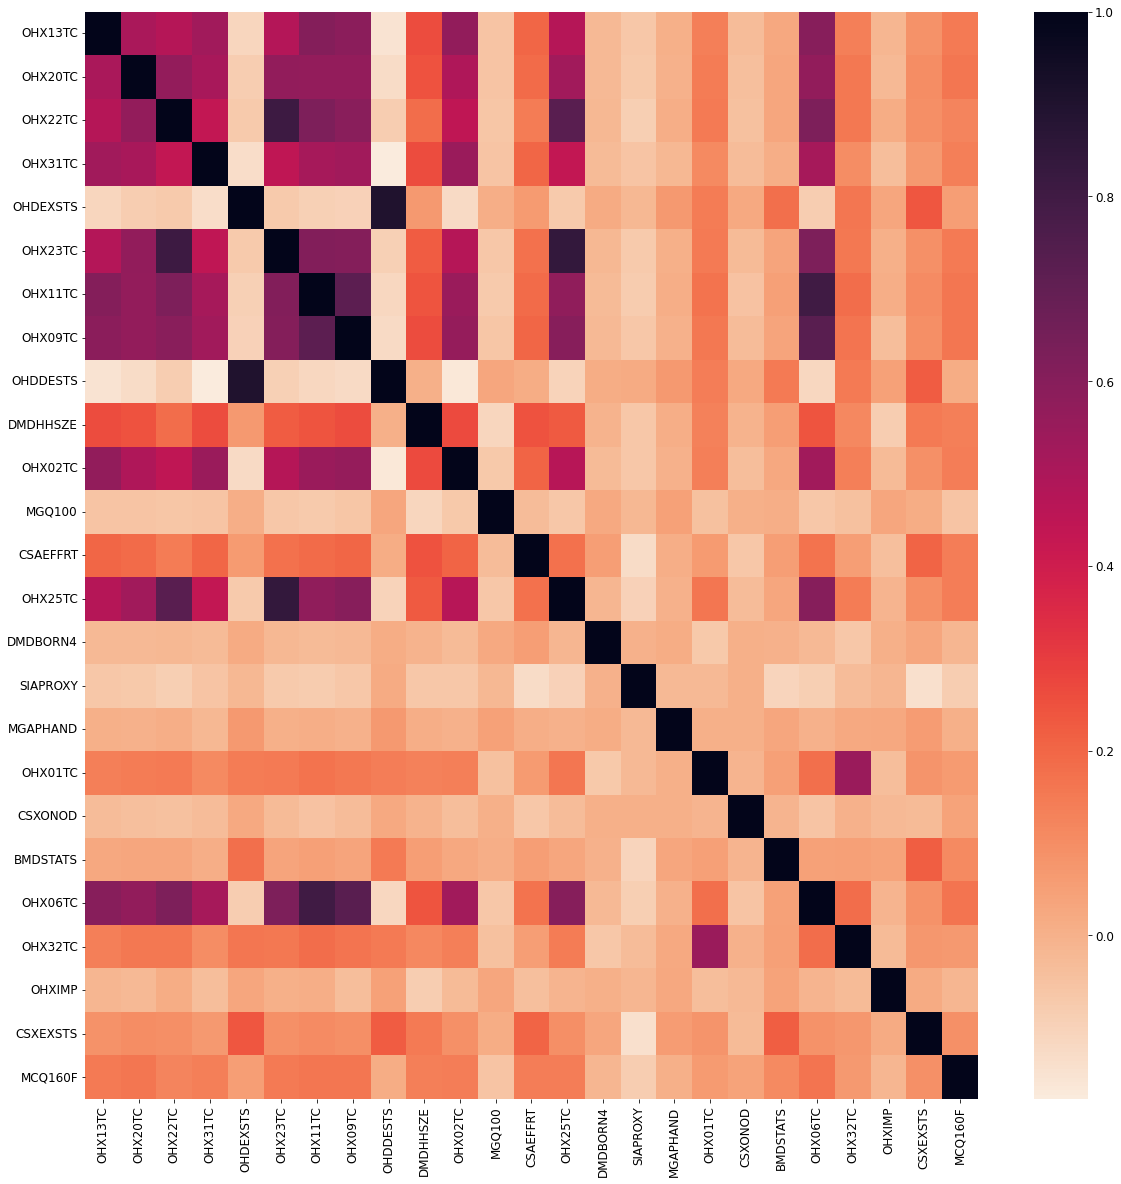

In [30]:
# sns.axes_style("white")
ax = plt.subplots(figsize=(20, 20))

corr = df_final.corr()

# sns.heatmap(corr, vmin=-1, vmax=1, cmap=sns.cm.rocket_r)
sns.heatmap(corr, cmap=sns.cm.rocket_r)

## IV. Model Training

### Train/Test Split

In [31]:
X_ = df_final.loc[:, df_final.columns != 'MCQ160F']
y = df_final.MCQ160F

### Data Normalization

In [32]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
X = pd.DataFrame(minmax.fit_transform(X_), columns=X_.columns)
X

,OHX13TC,OHX20TC,OHX22TC,OHX31TC,OHDEXSTS,OHX23TC,OHX11TC,OHX09TC,OHDDESTS,DMDHHSZE,...,DMDBORN4,SIAPROXY,MGAPHAND,OHX01TC,CSXONOD,BMDSTATS,OHX06TC,OHX32TC,OHXIMP,CSXEXSTS
0,0.75,0.75,0.666667,0.666667,0.0,0.666667,0.75,0.666667,0.0,0.666667,...,0.000000,1.0,0.0,0.666667,0.000000,0.000000,0.75,0.666667,1.0,0.0
1,0.25,1.00,0.000000,0.666667,0.0,0.000000,0.25,0.000000,0.0,0.000000,...,0.000000,1.0,0.0,0.666667,0.666667,0.000000,0.25,0.666667,1.0,0.0
2,0.25,0.25,0.000000,0.666667,0.0,0.000000,0.25,0.000000,0.0,0.666667,...,0.000000,1.0,0.0,0.666667,0.666667,0.000000,0.25,0.666667,1.0,0.0
3,0.25,0.75,0.000000,0.666667,0.0,0.000000,0.25,0.666667,0.0,0.666667,...,0.000000,1.0,0.0,0.666667,0.666667,0.666667,0.25,0.666667,1.0,0.5
4,0.75,0.75,0.000000,0.666667,0.0,0.000000,0.25,0.000000,0.0,0.000000,...,0.000000,1.0,0.0,0.666667,0.666667,0.000000,0.75,0.666667,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5578,0.75,0.75,0.000000,1.000000,0.0,0.000000,1.00,1.000000,0.0,0.666667,...,0.000000,1.0,0.0,0.666667,0.666667,0.000000,0.25,0.666667,1.0,0.0
5579,0.25,0.25,0.000000,0.666667,0.0,0.000000,0.25,0.000000,0.0,0.666667,...,0.000000,1.0,0.0,0.666667,0.666667,0.000000,0.25,0.666667,1.0,0.0
5580,0.25,0.25,0.000000,0.000000,1.0,0.000000,0.25,0.000000,1.0,0.000000,...,0.013158,1.0,1.0,0.666667,0.666667,0.000000,0.25,0.666667,1.0,0.0
5581,0.25,0.25,0.000000,0.000000,0.0,0.000000,0.25,0.000000,0.0,0.000000,...,0.000000,1.0,0.0,0.000000,0.666667,0.000000,0.25,0.666667,1.0,0.0


### Upsampling Minoroty Class with SMOTE
Note that it is important to only oversample after train/test split, so the testing data will not leak.

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11)

In [34]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)
# X_test_sm, y_test_sm = smote.fit_sample(X_test, y_test)

X_train_sm = pd.DataFrame(X_train_sm, columns=X.columns)
# X_test_sm = pd.DataFrame(X_test_sm, columns=X.columns)

In [35]:
print('X train shape: ', X_train_sm.shape)
print('y train values: \n', y_train_sm.value_counts())
print()
print('X test shape: ', X_test.shape)
print('y test values: \n', y_test.value_counts())

X train shape:  (8066, 24)
y train values: 
 0.0    4033
1.0    4033
Name: MCQ160F, dtype: int64

X test shape:  (1396, 24)
y test values: 
 0.0    1356
1.0      40
Name: MCQ160F, dtype: int64


In [36]:
mscore = []

### Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=100, solver='lbfgs',
                         class_weight='balanced', random_state=11).fit(X_train_sm, y_train_sm)
y_pred = clf.predict(X_test)

print('Accuracy Score:', clf.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['Logistic Regression', clf.score(X_test, y_test)])

print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

Accuracy Score: 0.7800859598853869
Prediction: [0. 0. 0. ... 0. 0. 1.]
              precision    recall  f1-score   support

         0.0       0.99      0.78      0.87      1356
         1.0       0.09      0.75      0.16        40

    accuracy                           0.78      1396
   macro avg       0.54      0.77      0.52      1396
weighted avg       0.96      0.78      0.85      1396

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        1059         297
True[1]          10          30


,Predict[0],Predict[1]
True[0],1059,297
True[1],10,30


### Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(
    n_estimators=150, criterion='gini', max_depth=5, random_state=11)
rnd_clf.fit(X_train_sm, y_train_sm)

y_pred = rnd_clf.predict(X_test)

print('Accuracy Score:', rnd_clf.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['Random Forest', rnd_clf.score(X_test, y_test)])

print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

Accuracy Score: 0.8617478510028653
Prediction: [0. 0. 0. ... 0. 0. 1.]
              precision    recall  f1-score   support

         0.0       0.99      0.87      0.92      1356
         1.0       0.12      0.57      0.19        40

    accuracy                           0.86      1396
   macro avg       0.55      0.72      0.56      1396
weighted avg       0.96      0.86      0.90      1396

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        1180         176
True[1]          17          23


,Predict[0],Predict[1]
True[0],1180,176
True[1],17,23


### Gradient Boosting Decision Trees

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(
    learning_rate=0.1, n_estimators=10, random_state=11)
gbc.fit(X_train_sm, y_train_sm)

y_pred = gbc.predict(X_test)

print('Accuracy Score:', gbc.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['GradientBoosting', gbc.score(X_test, y_test)])

print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

Accuracy Score: 0.7464183381088825
Prediction: [0. 0. 0. ... 0. 0. 1.]
              precision    recall  f1-score   support

         0.0       0.99      0.75      0.85      1356
         1.0       0.07      0.65      0.13        40

    accuracy                           0.75      1396
   macro avg       0.53      0.70      0.49      1396
weighted avg       0.96      0.75      0.83      1396

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        1016         340
True[1]          14          26


,Predict[0],Predict[1]
True[0],1016,340
True[1],14,26


### AdaBoostClassifier

In [40]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(learning_rate=0.01, n_estimators=30, random_state=11)
ada.fit(X_train_sm, y_train_sm)

y_pred = ada.predict(X_test)

print('Accuracy Score:', ada.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['Adaptive Boosting', ada.score(X_test, y_test)])

# from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

Accuracy Score: 0.6210601719197708
Prediction: [0. 0. 0. ... 0. 1. 1.]
              precision    recall  f1-score   support

         0.0       0.99      0.62      0.76      1356
         1.0       0.06      0.80      0.11        40

    accuracy                           0.62      1396
   macro avg       0.52      0.71      0.43      1396
weighted avg       0.96      0.62      0.74      1396

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]         835         521
True[1]           8          32


,Predict[0],Predict[1]
True[0],835,521
True[1],8,32


### SVM

In [41]:
from sklearn.svm import SVC
svm_clf = SVC(kernel='sigmoid', gamma='auto', random_state=11)
svm_clf.fit(X_train_sm, y_train_sm)
y_pred = svm_clf.predict(X_test)

print('Accuracy Score:', svm_clf.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['SVM', svm_clf.score(X_test, y_test)])

# from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

Accuracy Score: 0.7435530085959885
Prediction: [0. 0. 0. ... 0. 0. 1.]
              precision    recall  f1-score   support

         0.0       0.99      0.74      0.85      1356
         1.0       0.08      0.78      0.15        40

    accuracy                           0.74      1396
   macro avg       0.54      0.76      0.50      1396
weighted avg       0.97      0.74      0.83      1396

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        1007         349
True[1]           9          31


,Predict[0],Predict[1]
True[0],1007,349
True[1],9,31


### XGBoost

In [42]:
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

xgbc = XGBClassifier(eta=0.01, max_depth=3)
# xgbc = XGBClassifier(eta=0.01)
xgbc.fit(X_train_sm, y_train_sm)

y_pred = xgbc.predict(X_test)

print('Accuracy Score:', svm_clf.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['XGBoost', xgbc.score(X_test, y_test)])

print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

[20:12:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda\envs\ReconNet\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy Score: 0.7435530085959885
Prediction: [0. 0. 0. ... 0. 0. 1.]
              precision    recall  f1-score   support

         0.0       0.99      0.75      0.85      1356
         1.0       0.07      0.65      0.13        40

    accuracy                           0.74      1396
   macro avg       0.53      0.70      0.49      1396
weighted avg       0.96      0.74      0.83      1396

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        1011         345
True[1]          14          26


,Predict[0],Predict[1]
True[0],1011,345
True[1],14,26


## V. Model Comparison

In [43]:
mscore.sort(key=lambda x: x[1], reverse=True)
mscore

[['Random Forest', 0.8617478510028653],
 ['Logistic Regression', 0.7800859598853869],
 ['GradientBoosting', 0.7464183381088825],
 ['SVM', 0.7435530085959885],
 ['XGBoost', 0.7428366762177651],
 ['Adaptive Boosting', 0.6210601719197708]]

Accracy Score: 

Random Forest: 86.17%
Logistic Regression: 78.01%
GradientBoosting: 74.64%
SVM: 74.36%
XGBoost: 74.28%
Adaptive Boosting: 62.11%


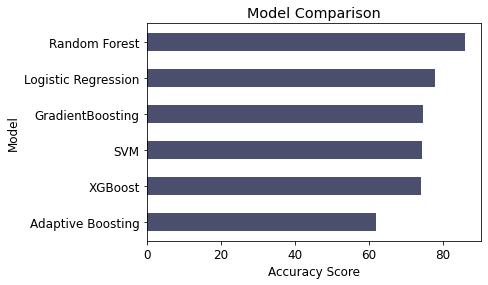

In [44]:
model = list(i[0] for i in mscore)
score = list(round(i[1]*100, 2) for i in mscore)

print('Accracy Score: \n')
for m, s in zip(model, score):
    print(f'{m}: {s}%')


# creating horizontal bar plot
# this color is called independence, how cool!
plt.barh(model, score, height=0.5, color='#4B4E6D')

plt.xlabel("Accuracy Score")
plt.ylabel("Model")
plt.title("Model Comparison")
plt.gca().invert_yaxis()
plt.show()

## VI. Future Work
1. Model optimization/hyperparameter tuning
2. Ensamble
3. ROC/AUC comparison
